In [ ]:
# install kaggle package
!pip install -q kaggle

Nama: Putri Wulandari

Kelas: Machine Learning dan Front End

Proyek Akhir : Image Classification Model Deployment

BISMILLAH DIACC

In [ ]:
# upload kaggleee

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"putriwulandari12345","key":"983467ba58df84cfd8fd9df601c25432"}'}

In [ ]:

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [ ]:
!kaggle datasets download -d madisona/translated-animals10

 99% 578M/586M [00:03<00:00, 135MB/s]
100% 586M/586M [00:03<00:00, 157MB/s]


In [ ]:
# UNZIP
!mkdir animales
!unzip -qq translated-animals10.zip -d animales
!ls animales

animals10


In [ ]:
#MEMBUKA FOLDER
!ls animales/animals10/raw-img/

butterfly  cat	chicken  cow  dog  elephant  horse  sheep  spider  squirrel


In [ ]:
import os

animales = os.path.join('/content/animales/animals10/raw-img')

print(os.listdir(animales))

['cat', 'elephant', 'dog', 'butterfly', 'spider', 'horse', 'sheep', 'cow', 'squirrel', 'chicken']


In [ ]:
import shutil

ignore_animales = ['spider', 'dog', 'squirrel', 'cat', 'chicken', 'sheep']

for x in ignore_animales:
  path = os.path.join(animales, x)
  shutil.rmtree(path)

In [ ]:
list_animales = os.listdir(animales)
print(list_animales)

['elephant', 'butterfly', 'horse', 'cow']


In [ ]:
from PIL import Image
total = 0

for x in list_animales:
  dir = os.path.join(animales, x)
  y = len(os.listdir(dir))
  print(x+':', y)
  total = total + y
  
  img_name = os.listdir(dir)
  for z in range(4):
    img_path = os.path.join(dir, img_name[z])
    img = Image.open(img_path)
    print('-',img.size)
  print('---------------')

print('\nTotal :', total)

elephant: 1446
- (300, 171)
- (640, 423)
- (300, 200)
- (300, 225)
---------------
butterfly: 2112
- (300, 200)
- (243, 300)
- (300, 188)
- (300, 199)
---------------
horse: 2623
- (300, 235)
- (300, 225)
- (300, 240)
- (300, 234)
---------------
cow: 1866
- (300, 249)
- (300, 240)
- (300, 219)
- (300, 300)
---------------

Total : 8047


<function matplotlib.pyplot.show(*args, **kw)>

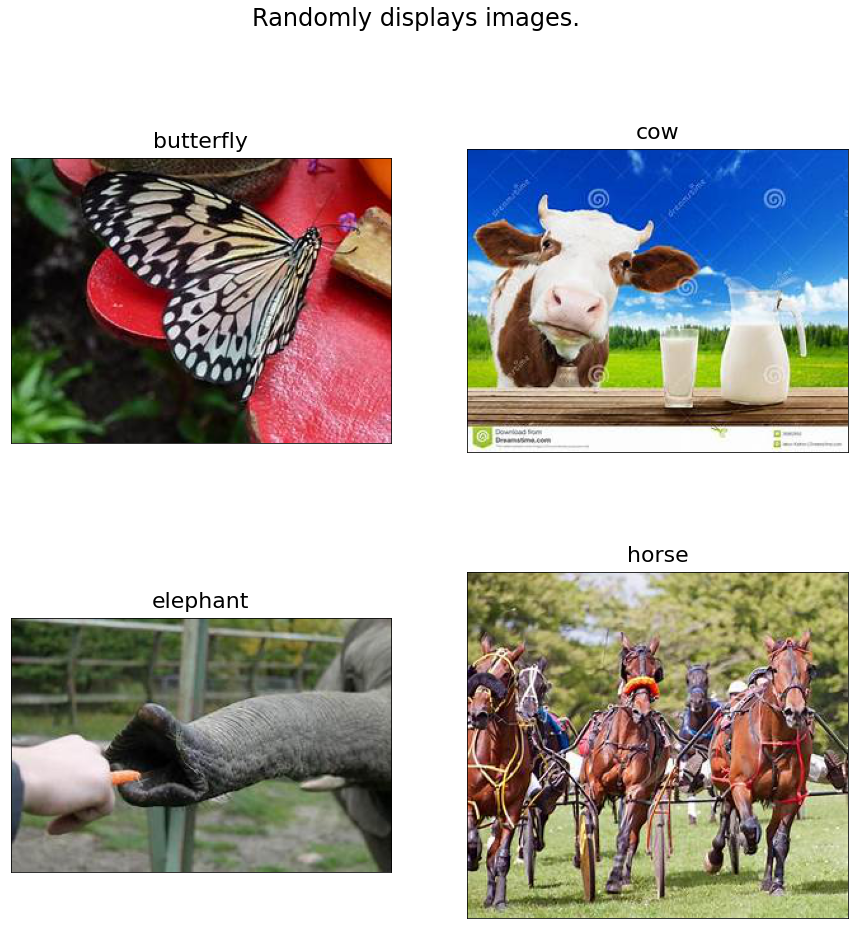

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle("Randomly displays images.", fontsize=24)
animales_sorted = sorted(list_animales)
animales_id = 0
for i in range(2):
  for j in range(2):
    try:
      animales_selected = animales_sorted[animales_id] 
      animales_id += 1
    except:
      break
    if animales_selected == '.TEMP':
        continue
    animales_selected_images = os.listdir(os.path.join(animales, animales_selected))
    animales_selected_random = np.random.choice(animales_selected_images)
    img = plt.imread(os.path.join(animales, animales_selected, animales_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(animales_selected, pad=10, fontsize=22)
    
plt.setp(ax, xticks=[],yticks=[])
plt.show

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
 
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2   
)

In [ ]:
batch_size = 256

data_train = train_datagen.flow_from_directory(
    animales,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

data_val = train_datagen.flow_from_directory(
    animales, 
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Found 6439 images belonging to 4 classes.
Found 1608 images belonging to 4 classes.


In [ ]:
import tensorflow as tf
# from tensorflow.keras import applications, optimizers

tf.device('/device:GPU:0')

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [ ]:
# Penggunaan Callback mencegah overfitting dan menghentikan training setelah akurasi terpenuhi
class CNNCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.92 and logs.get('val_accuracy')>0.92):
      print("\nAkurasi di atas 92%, dihentikan Sekarang yaaa!")
      self.model.stop_training = True

callbacks = CNNCallback()

In [ ]:
# compile model dengan 'adam' optimizer loss function 'categorical_crossentropy' 

model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [43]:
history = model.fit(
    data_train,
    steps_per_epoch = 25, # 1312 images = batch_size * steps
    epochs = 15,
    validation_data = data_val,
    validation_steps = 5, # 876 images = batch_size * steps
    verbose =1,
      callbacks=[callbacks],
    
)

Epoch 1/15
25/25 [==============================] - 465s 19s/step - loss: 0.3735 - accuracy: 0.8509 - val_loss: 0.4100 - val_accuracy: 0.8359
Epoch 2/15
25/25 [==============================] - 458s 18s/step - loss: 0.3883 - accuracy: 0.8426 - val_loss: 0.4157 - val_accuracy: 0.8258
Epoch 3/15
25/25 [==============================] - 456s 18s/step - loss: 0.3606 - accuracy: 0.8556 - val_loss: 0.4297 - val_accuracy: 0.8422
Epoch 4/15
25/25 [==============================] - 449s 18s/step - loss: 0.3628 - accuracy: 0.8580 - val_loss: 0.4263 - val_accuracy: 0.8438
Epoch 5/15
25/25 [==============================] - 458s 18s/step - loss: 0.3583 - accuracy: 0.8619 - val_loss: 0.4572 - val_accuracy: 0.8289
Epoch 6/15
25/25 [==============================] - 456s 18s/step - loss: 0.3550 - accuracy: 0.8601 - val_loss: 0.4207 - val_accuracy: 0.8383
Epoch 7/15
25/25 [==============================] - 455s 18s/step - loss: 0.3637 - accuracy: 0.8546 - val_loss: 0.4231 - val_accuracy: 0.8320
Epoch 

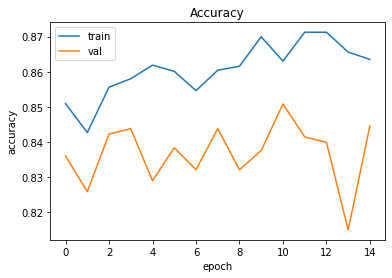

In [44]:
#AKURASI PLOT
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

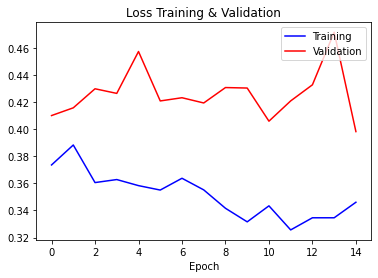

In [45]:
#VALIDAsi dan Training
plt.plot(history.history['loss'], label='Training', color='blue')
plt.plot(history.history['val_loss'], label='Validation', color='red')
plt.title('Loss Training & Validation')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

In [46]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

In [47]:
# Defining list with labels
labels = ['elephant', 'butterfly', 'horse', 'cow']

# Check point
# Showing labels
print(labels)

['elephant', 'butterfly', 'horse', 'cow']


In [48]:
# Generating Numpy array with True classes' indexesss
y_true = np.random.randint(low=0, high=5, size=100, dtype=int)


# Check point
# Showing array
print(y_true)

[3 0 1 1 4 3 3 2 4 3 1 3 0 3 4 4 1 4 0 3 1 0 1 2 2 4 1 0 4 4 3 0 2 3 4 4 0
 3 4 1 1 0 3 0 1 4 4 2 4 1 2 0 3 3 3 2 4 1 1 0 4 1 1 0 3 3 0 1 3 1 1 4 4 1
 2 4 0 2 0 2 4 1 2 3 2 2 2 2 4 3 3 1 0 4 4 1 4 1 1 1]


In [49]:
# Calculating number of samples for every classss
# Iterating all classes' indexes in 'y_true' arrayyy
# Using Numpy function 'unique'
# Returning sorted unique elements and their frequenciesss

classesIndexes, classesFrequency = np.unique(y_true, return_counts=True)


# Printing frequency (number of samples) for every class
print('classes indexes:' , classesIndexes)
print('\n')
print('classes frequency:', classesFrequency)

classes indexes: [0 1 2 3 4]


classes frequency: [16 25 15 20 24]


In [50]:
# Making copy of array with True classes' indexess

y_predicted = np.copy(y_true)

In [51]:
# Choosing randomly 25% of classes to be changedd
ii = np.random.randint(low=0, high=len(y_true), size=int(0.25 * len(y_true)), dtype=int)


# Check pointt
# Showing chosen indexess
print(ii)

[14 48 40 95 19 64 59 48 63 92 14 22 67  4 42 35 22 20 68 32 75 19 41 20
 36]


In [52]:
# Iteratinggg chosen indexes and replacing them with other classes' indexes
for i in ii:

    # Generating new class index
    y_predicted[i] = np.random.randint(low=0, high=5, dtype=int)
    
    
    # Check pointt
    # Showing difference between True classes' indexes and Predicted oness
    print('index = {0:2d}, True class => {1}, {2} <= Predicted class'.
          format(i, y_true[i], y_predicted[i]))

index = 14, True class => 4, 1 <= Predicted class
index = 48, True class => 4, 2 <= Predicted class
index = 40, True class => 1, 2 <= Predicted class
index = 95, True class => 1, 1 <= Predicted class
index = 19, True class => 3, 0 <= Predicted class
index = 64, True class => 3, 0 <= Predicted class
index = 59, True class => 0, 2 <= Predicted class
index = 48, True class => 4, 4 <= Predicted class
index = 63, True class => 0, 0 <= Predicted class
index = 92, True class => 0, 4 <= Predicted class
index = 14, True class => 4, 2 <= Predicted class
index = 22, True class => 1, 0 <= Predicted class
index = 67, True class => 1, 4 <= Predicted class
index =  4, True class => 4, 4 <= Predicted class
index = 42, True class => 3, 0 <= Predicted class
index = 35, True class => 4, 0 <= Predicted class
index = 22, True class => 1, 3 <= Predicted class
index = 20, True class => 1, 4 <= Predicted class
index = 68, True class => 3, 0 <= Predicted class
index = 32, True class => 2, 1 <= Predicted class


In [53]:
# Confusion Matrix is a two dimensional matrix that visualizes the performance,,
# and makes it easy to see confusion between classes,,
# by providing a picture of interrelationn

# Each row represents a number of actual, True class
# Each column represents a number of predicted classs

# Computing Confusion Matrix to evaluate accuracy of classificationnnn
c_m = confusion_matrix(y_true, y_predicted)

# Showing Confusion Matrix in form of 2D Numpy arrayyy
print(c_m)

[[13  0  1  0  2]
 [ 0 21  1  2  1]
 [ 0  1 14  0  0]
 [ 4  0  0 16  0]
 [ 1  0  2  0 21]]


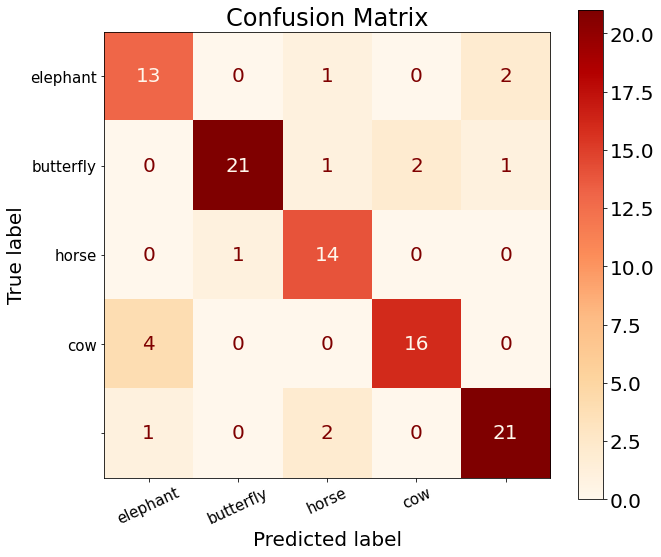

In [54]:
%matplotlib inline


# Settingg default size dari the plott
# Settingg default fontsize used in the plot
plt.rcParams['figure.figsize'] = (10.0, 9.0)
plt.rcParams['font.size'] = 20


# Implementinggg visualization of Confusion Matrix
display_c_m = ConfusionMatrixDisplay(c_m, display_labels=labels)


# Plotting Confusion Matrixxx
# Setting colour map to be useddd
display_c_m.plot(cmap='OrRd', xticks_rotation=25)
# Other possible options for colour map are:
# 'autumn_r', 'Blues', 'cool', 'Greens', 'Greys', 'PuRd', 'copper_r'


# Settinggg fontsize for xticks and yticks
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


# Giving name to the plott
plt.title('Confusion Matrix', fontsize=24)


# Saving plott
plt.savefig('confusion_matrix.png', transparent=True, dpi=500)


# Showing the plott
plt.show()

In [55]:
# Showing the main classification metricsss

print(classification_report(y_true, y_predicted))

              precision    recall  f1-score   support

           0       0.72      0.81      0.76        16
           1       0.95      0.84      0.89        25
           2       0.78      0.93      0.85        15
           3       0.89      0.80      0.84        20
           4       0.88      0.88      0.88        24

    accuracy                           0.85       100
   macro avg       0.84      0.85      0.84       100
weighted avg       0.86      0.85      0.85       100



In [56]:
import pathlib

# Menyimpan model dalam format SavedModelll
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)
 
# Convert SavedModel menjadi Rice Deseased.tflitee
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()
 
tflite_model_file = pathlib.Path('Rice_Desease.tflite')
tflite_model_file.write_bytes(tflite_model)

13900212